In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import InputLayer, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
from sklearn.utils import resample
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from xgboost import XGBClassifier

2025-05-01 16:11:54.928069: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746115915.123599      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746115915.179877      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_path = os.path.join('/kaggle/input/covidx-cxr2')
train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path,'test')
train_df = pd.read_csv(os.path.join(data_path, 'train.txt'), sep=" ", index_col=None, header=None)
test_df = pd.read_csv(os.path.join(data_path, 'test.txt'), sep=" ", index_col=None, header=None)


In [3]:
val_data_path = os.path.join(data_path,'val')

val_df = pd.read_csv(os.path.join(data_path, 'val.txt'), sep=" ", index_col=None, header=None)


In [4]:
val_df.head()

,0,1,2,3
0,ANON196,CR.1.2.840.113564.1722810170.20200318082923328...,positive,actmed
1,ANON170,CR.1.2.840.113564.1722810170.20200320011259312...,positive,actmed
2,S03044,sub-S03044_ses-E06138_run-1_bp-chest_vp-ap_cr-...,positive,bimcv
3,S03044,sub-S03044_ses-E07712_run-1_bp-chest_vp-ap_cr-...,positive,bimcv
4,S03044,sub-S03044_ses-E06790_run-1_bp-chest_vp-pa_dx-...,positive,bimcv


In [32]:
train_df.head()

,0,1,2,3
0,379,1e64990d1b40c1758a2aaa9c7f7a85_jumbo.jpeg,negative,cohen
1,379,7223b8ad031187d9a142d7f7ca02c9_jumbo.jpeg,negative,cohen
2,380,3392dc7d262e28423caca517f98c2e_jumbo.jpeg,negative,cohen
3,380,ec3a480c0926ded74429df416cfb05_jumbo.jpeg,negative,cohen
4,382,a72aeb349a63c79ed24e473c434efe_jumbo.jpg,negative,cohen


In [5]:
test_df.head()

,0,1,2,3
0,419639-003251,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive,ricord
1,419639-001464,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive,ricord
2,419639-000918,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive,ricord
3,419639-003318,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive,ricord
4,419639-001015,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive,ricord


In [6]:
train_df.drop(columns = [0,3], axis=1, inplace=True)
test_df.drop(columns = [0,3], axis=1, inplace=True)
val_df.drop(columns = [0,3], axis=1, inplace=True)

In [7]:
train_df = train_df.rename(columns = {1:'image_name', 2:'diagnosis'})
test_df = test_df.rename(columns = {1:'image_name', 2:'diagnosis'})
val_df=val_df.rename(columns = {1:'image_name', 2:'diagnosis'})


In [8]:
train_df.head()


,image_name,diagnosis
0,1e64990d1b40c1758a2aaa9c7f7a85_jumbo.jpeg,negative
1,7223b8ad031187d9a142d7f7ca02c9_jumbo.jpeg,negative
2,3392dc7d262e28423caca517f98c2e_jumbo.jpeg,negative
3,ec3a480c0926ded74429df416cfb05_jumbo.jpeg,negative
4,a72aeb349a63c79ed24e473c434efe_jumbo.jpg,negative


In [9]:
train_df.diagnosis.value_counts()

diagnosis
positive    57199
negative    10664
Name: count, dtype: int64

In [10]:
val_df.diagnosis.value_counts()

diagnosis
positive    4241
negative    4232
Name: count, dtype: int64

In [11]:
train_df.isnull().sum()

image_name    0
diagnosis     0
dtype: int64

In [12]:
train_df.duplicated().sum()

0

In [13]:
val_df.isnull().sum()

image_name    0
diagnosis     0
dtype: int64

In [14]:
val_df.duplicated().sum()

0

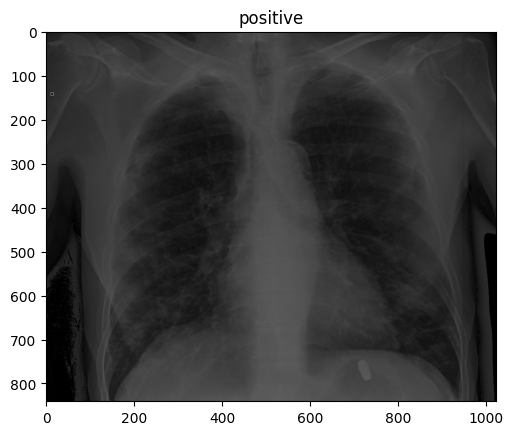

(841, 1024, 3)

In [19]:
rand_indx = np.random.randint(0,len(train_df),1)[0]
img = cv2.imread(os.path.join(train_data_path, train_df.image_name[rand_indx]))
plt.imshow(img/255)
plt.title(train_df.diagnosis[rand_indx])
plt.show()
img.shape


In [20]:
from sklearn.model_selection import train_test_split

In [21]:
train_df, df_test = train_test_split(train_df, test_size=0.2, stratify=train_df['diagnosis'], random_state=42)

In [22]:
df_majority = train_df[train_df['diagnosis'] == 'positive']
df_minority = train_df[train_df['diagnosis'] == 'negative']

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=len(df_majority), 
                                 random_state=42)

train_df = pd.concat([df_majority, df_minority_upsampled])
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [23]:
train_df.diagnosis.value_counts()

diagnosis
positive    45759
negative    45759
Name: count, dtype: int64

In [24]:
df_test.diagnosis.value_counts()

diagnosis
positive    11440
negative     2133
Name: count, dtype: int64

In [25]:
def custom_preprocess(img):
    img = img.astype(np.uint8)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)
    mask = cv2.medianBlur(mask, 5)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    img = cv2.bitwise_and(img, mask)

    return img.astype(np.float32) / 255.0

In [27]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    preprocessing_function=custom_preprocess,
    rotation_range=15, zoom_range=0.1, horizontal_flip=True,
    width_shift_range=0.05, height_shift_range=0.05
).flow_from_dataframe(
    dataframe=train_df, directory=train_data_path,
    x_col='image_name', y_col='diagnosis',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=True
)

val_gen = ImageDataGenerator(
    preprocessing_function=custom_preprocess
).flow_from_dataframe(
    dataframe=val_df, directory=val_data_path,
    x_col='image_name', y_col='diagnosis',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=False
)

Found 91518 validated image filenames belonging to 2 classes.
Found 8473 validated image filenames belonging to 2 classes.


In [35]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Dropout, ReLU, BatchNormalization, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

In [63]:
def mobilenetv2(input_shape=(224, 224, 3), dropout_rate=0.1):
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Step 2: freeze base

    inputs = Input(shape=input_shape)
    x = base_model(inputs)
    
    # Conv layer
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Residual Conv (2,2), AvgPool
    x = Conv2D(64, (2, 2), activation='relu', padding='same')(x)
    x = AveragePooling2D(pool_size=(2, 2), padding='same')(x)

    # Residual Conv (1,1), stride=2, AvgPool + Dropout
    x = Conv2D(64, (1, 1), strides=2, activation='relu', padding='same')(x)
    x = AveragePooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(dropout_rate)(x)

    # Residual Conv (2,2), stride=1, MaxPool + Dropout
    x = Conv2D(128, (2, 2), strides=1, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x) 
    x = Dropout(dropout_rate)(x)

    # Two Conv (1,1), stride=2, MaxPool + Dropout
    for _ in range(2):
        x = Conv2D(128, (1, 1), strides=2, activation='relu', padding='same')(x)
        x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)  
        x = Dropout(dropout_rate)(x)

    # Conv (2,2), stride=2, Dropout
    x = Conv2D(256, (2, 2), strides=2, activation='relu', padding='same')(x)
    x = Dropout(dropout_rate)(x)

    # Conv (2,2), stride=1, AvgPool + Dropout
    x = Conv2D(256, (2, 2), strides=1, activation='relu', padding='same')(x)
    x = AveragePooling2D(pool_size=(2, 2), padding='same')(x)  
    x = Dropout(dropout_rate)(x)

    # Final proposed layer (Conv 3x3)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)

    # Final classification layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(96, activation='relu')(x)  # Tuned hidden layer
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)  # Binary classification

    model = Model(inputs=inputs, outputs=outputs)
    return model
early_stopping = EarlyStopping(monitor='val_loss',  
                               patience=3,          
                               restore_best_weights=True,  
                               verbose=1)           

model = mobilenetv2()
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-6), 
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 7, 7, 32)            │         368,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 7, 7, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 7, 7, 64)            │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_9                  │ (None, 4, 4, 64)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 2, 2, 64)            │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_10                 │ (None, 1, 1, 64)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 1, 1, 128)           │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 1, 1, 128)           │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 1, 1, 128)           │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 1, 1, 256)           │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 1, 1, 256)           │              

 Total params: 4,328,353 (16.51 MB)

 Trainable params: 2,070,305 (7.90 MB)

 Non-trainable params: 2,258,048 (8.61 MB)

In [37]:
model.fit(train_gen, epochs=10, validation_data=val_gen, callbacks=[early_stopping])

Epoch 1/10
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2618s 907ms/step - accuracy: 0.4972 - loss: 0.6932 - precision_2: 0.4985 - recall_2: 0.0912 - val_accuracy: 0.4995 - val_loss: 0.6931 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/10
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2338s 816ms/step - accuracy: 0.5047 - loss: 0.6931 - precision_2: 0.5614 - recall_2: 0.0287 - val_accuracy: 0.5120 - val_loss: 0.6930 - val_precision_2: 0.8313 - val_recall_2: 0.0314
Epoch 3/10
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2249s 785ms/step - accuracy: 0.5226 - loss: 0.6930 - precision_2: 0.6297 - recall_2: 0.1070 - val_accuracy: 0.6134 - val_loss: 0.6926 - val_precision_2: 0.9051 - val_recall_2: 0.2542
Epoch 4/10
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2449s 854ms/step - accuracy: 0.5870 - loss: 0.6927 - precision_2: 0.7118 - recall_2: 0.2924 - val_accuracy: 0.6717 - val_loss: 0.6912 - val_precision_2: 0.9360 - val_recall_2: 0.3693
Epoch 5/10
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2404s 838ms/step - accuracy: 0.6349 - loss: 0.6913

In [38]:
test_gen = ImageDataGenerator(
    preprocessing_function=custom_preprocess
).flow_from_dataframe(
    dataframe=df_test, directory=train_data_path,
    x_col='image_name', y_col='diagnosis',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=False
)

Found 13573 validated image filenames belonging to 2 classes.


In [39]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
y_test = test_gen.classes
y_proba_test = model.predict(test_gen, verbose=1)
y_pred_test = (y_proba_test > 0.5).astype(int)
print("\nVGG19 Test Results:")
print(classification_report(y_test, y_pred_test))
print("Accuracy:", accuracy_score(y_test,y_pred_test))
print("AUC Score:", roc_auc_score(y_test,y_proba_test))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


425/425 ━━━━━━━━━━━━━━━━━━━━ 262s 603ms/step

VGG19 Test Results:
              precision    recall  f1-score   support

           0       0.46      0.90      0.61      2133
           1       0.98      0.81      0.88     11440

    accuracy                           0.82     13573
   macro avg       0.72      0.85      0.75     13573
weighted avg       0.90      0.82      0.84     13573

Accuracy: 0.8200103145951522
AUC Score: 0.9216159894957364


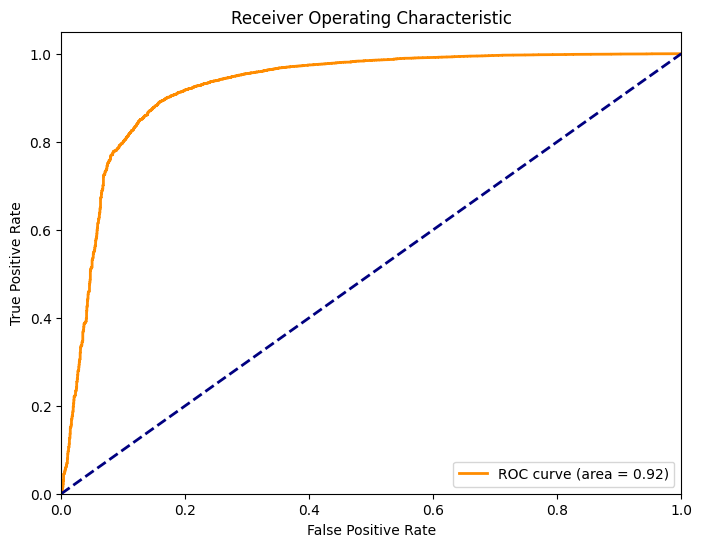

In [40]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


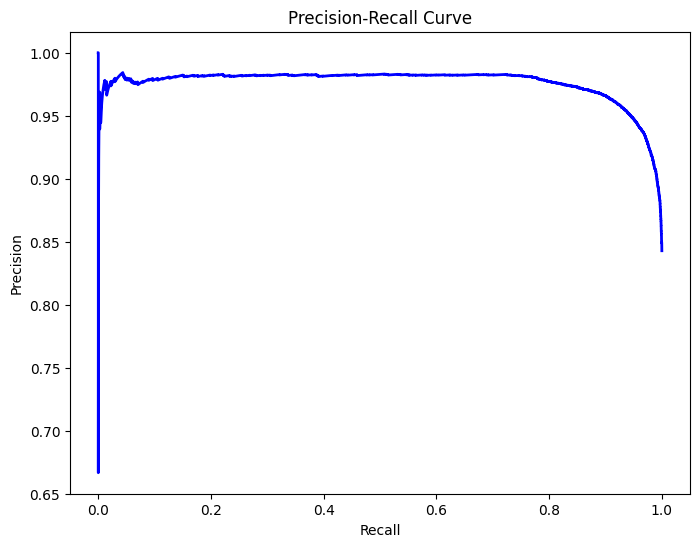

In [41]:
from sklearn.metrics import precision_recall_curve

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


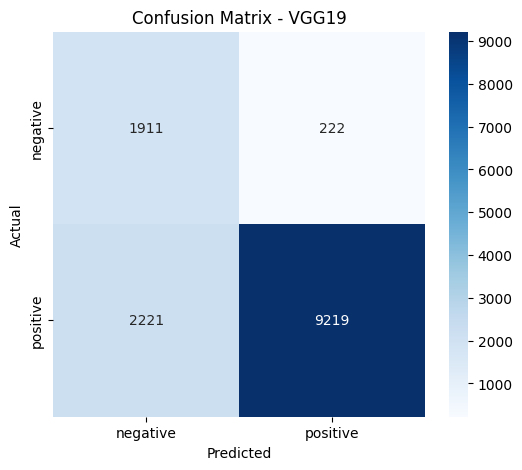

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_test)
class_labels = ['negative', 'positive']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - VGG19')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [43]:
pip install lime


Note: you may need to restart the kernel to use updated packages.


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

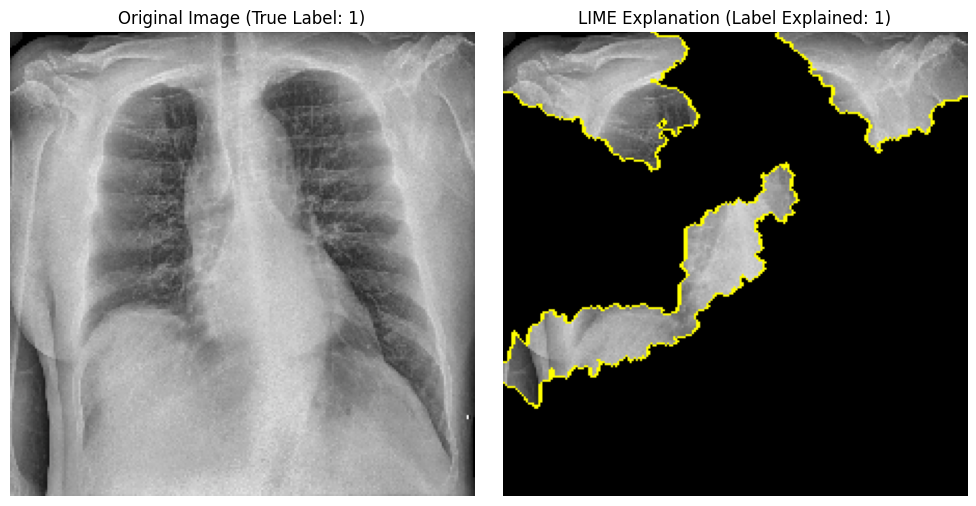

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Model Prediction: Class 0 = 0.5001, Class 1 = 0.4999


In [82]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
import tensorflow as tf

def predict_fn(images):
    processed_images = np.array([custom_preprocess(img) for img in images])
    preds = model.predict(processed_images)
    return np.concatenate([1 - preds, preds], axis=1)  

idx = 0
img_batch, label_batch = test_gen[idx]
img = img_batch[0]
true_label = int(label_batch[0])
if img.shape[-1] == 1:
    img = np.repeat(img, 3, axis=-1)
img_for_lime = (img * 255).astype(np.uint8)
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image=img_for_lime,
    classifier_fn=predict_fn,
    top_labels=2,
    hide_color=0,
    num_samples=1000
)
temp, mask = explanation.get_image_and_mask(
    label=true_label,  
    positive_only=True,
    num_features=5,
    hide_rest=True
)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f"Original Image (True Label: {true_label})")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"LIME Explanation (Label Explained: {true_label})")
plt.axis('off')

plt.tight_layout()
plt.show()

probs = predict_fn(np.expand_dims(img_for_lime, axis=0))
print(f"Model Prediction: Class 0 = {probs[0][0]:.4f}, Class 1 = {probs[0][1]:.4f}")


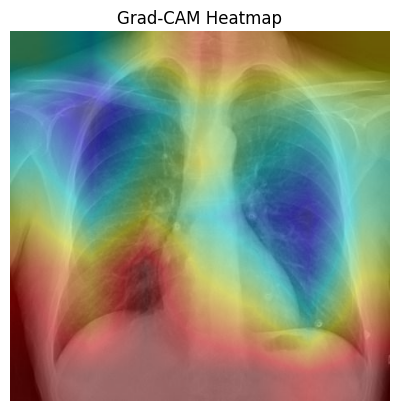

In [83]:
# Grad-CAM setup
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = tf.reduce_max(predictions)

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap(heatmap, img, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, colormap)
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
    return overlay

def load_and_preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR) 
    img_resized = cv2.resize(img, (224, 224))  
    return np.expand_dims(img_resized, axis=0)

def run_gradcam(img_path, model, last_conv_layer_name):
    img_array = preprocess_image(img_path)

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    original_img = cv2.imread(img_path)
    overlay = overlay_heatmap(heatmap, original_img)
    plt.imshow(overlay)
    plt.axis('off')
    plt.title("Grad-CAM Heatmap")
    plt.show()
img_path = "/kaggle/input/covidx-cxr2/train/000001-3.jpg"  
model = tf.keras.applications.MobileNetV2(weights='imagenet')  
last_conv_layer_name = "block_16_depthwise"  

run_gradcam(img_path, model, last_conv_layer_name)
